In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.spatial import distance_matrix

In [2]:
with open('data/contest_input.json') as f:
    contest_data = json.load(f)

In [3]:
contest_data.keys()

dict_keys(['couriers', 'orders', 'depots'])

In [4]:
couriers = pd.DataFrame(contest_data['couriers'])
orders = pd.DataFrame(contest_data['orders'])
depots = pd.DataFrame(contest_data['depots'])

In [5]:
couriers_x = couriers.location_x
couriers_y = couriers.location_y

In [6]:
couriers_x.shape

(300,)

In [7]:
drop_x = orders['dropoff_location_x']
drop_y = orders['dropoff_location_y']
pick_x = orders['pickup_location_x']
pick_y = orders['pickup_location_y']

In [8]:
depots.shape

(12, 3)

In [9]:
depots_x = depots.location_x
depots_y = depots.location_y

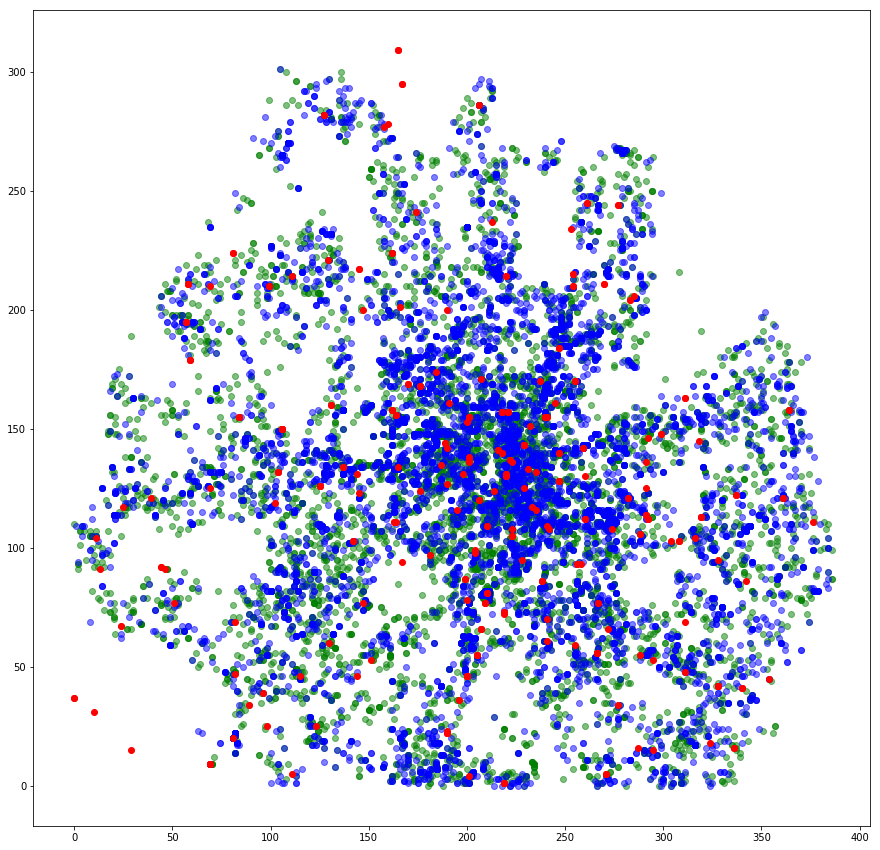

In [10]:
fig = plt.figure(figsize=(15,15))
plt.scatter(drop_x,drop_y, color='g', alpha=0.5)
plt.scatter(pick_x,pick_y, color='b', alpha=0.5)
plt.scatter(couriers_x, couriers_y, color='r')

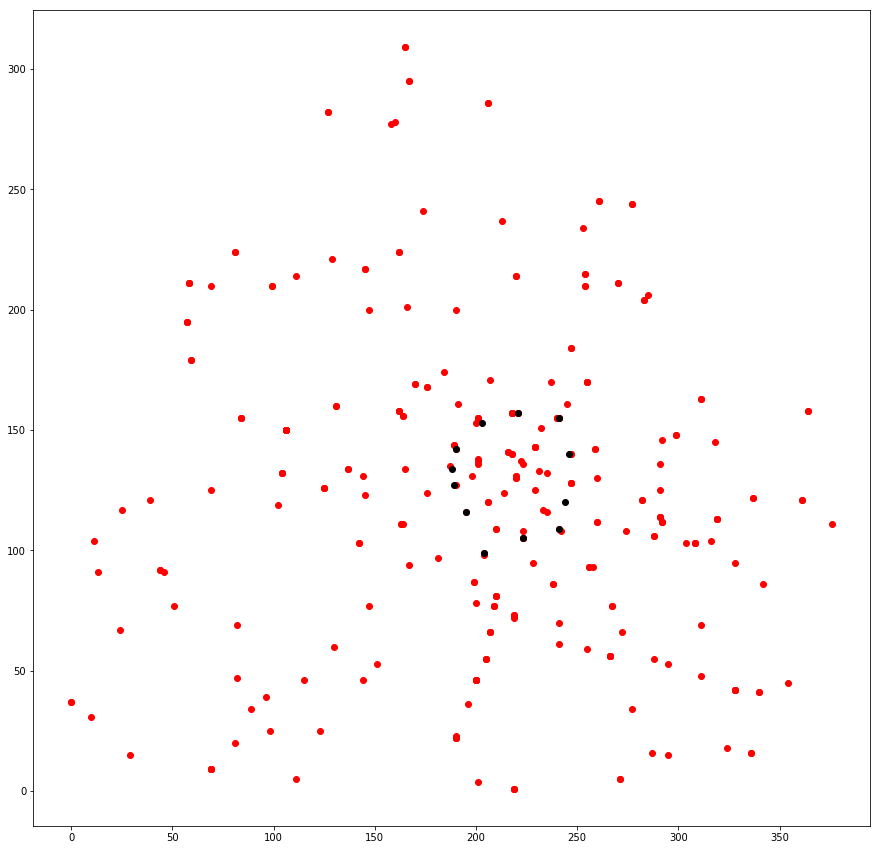

In [11]:
fig = plt.figure(figsize=(15,15))
plt.scatter(couriers_x, couriers_y, color='r')
plt.scatter(depots_x, depots_y, color='black')

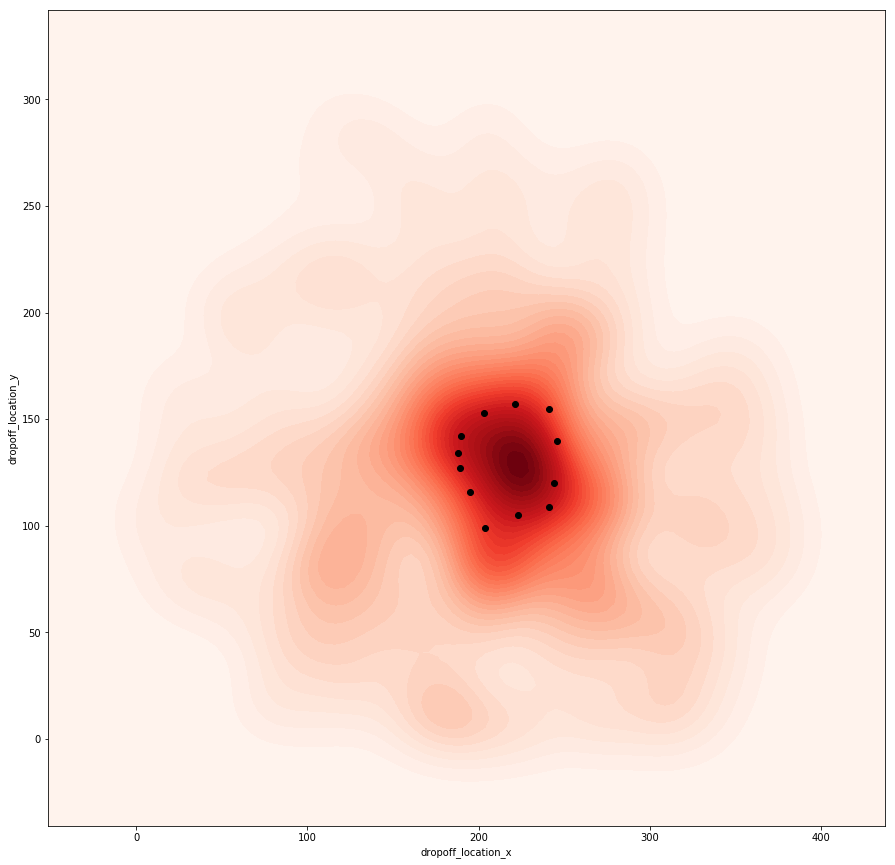

In [12]:
fig = plt.figure(figsize=(15,15))
sns.kdeplot(drop_x, drop_y, cmap="Reds", n_levels=50,shade=True)
plt.scatter(depots_x, depots_y, color='black')

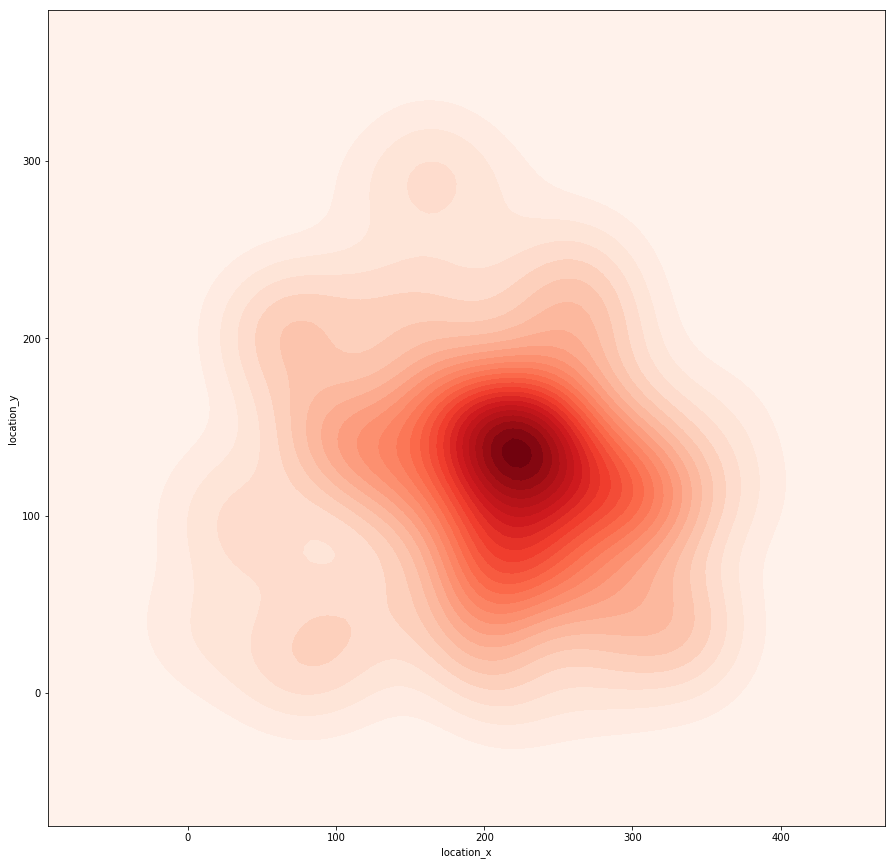

In [13]:
fig = plt.figure(figsize=(15,15))
sns.kdeplot(couriers_x, couriers_y, cmap="Reds", n_levels=30, shade=True)

In [14]:
orders.shape

(7303, 12)

In [15]:
couriers.shape

(300, 3)

In [16]:
def manh_distance(x0,y0,x1,y1):
    return np.abs(x0 - x1) + np.abs(y0-y1)

def courier_distance(x0,y0,x1,y1):
    return 10 + manh_distance(x0,y0,x1,y1)

In [17]:
def filter_orders(orders):
    orders = orders[(orders['pickup_to']>=360) 
                    & (orders['dropoff_to'] >=360) 
                    & (orders['payment'] > 0) 
                    & (orders['dropoff_to'] >= orders['pickup_to'])]
    return orders

In [18]:
orders = filter_orders(orders)

In [20]:
orders['spent_time'] = 10 + manh_distance(drop_x, drop_y, pick_x, pick_y)

In [21]:
orders['spent_time'].describe()

count    7218.000000
mean      152.792186
std        87.775763
min        10.000000
25%        85.000000
50%       142.000000
75%       208.000000
max       482.000000
Name: spent_time, dtype: float64

In [22]:
orders[:5]

,dropoff_from,dropoff_location_x,dropoff_location_y,dropoff_point_id,dropoff_to,order_id,payment,pickup_from,pickup_location_x,pickup_location_y,pickup_point_id,pickup_to,spent_time
0,600,252,197,60001,960,10001,313,480,284,235,40001,570,80
1,630,24,105,60002,660,10002,519,420,244,262,40002,450,387
2,1050,115,38,60003,1080,10003,380,390,225,141,40003,1020,223
4,840,12,101,60005,870,10005,482,300,233,108,40005,780,238
6,600,280,142,60007,660,10007,521,480,47,78,40007,540,307


In [137]:
%%time
drop_x = orders['dropoff_location_x'].values
drop_y = orders['dropoff_location_y'].values
pick_x = orders['pickup_location_x'].values
pick_y = orders['pickup_location_y'].values
money = orders['payment'].values
end2start = np.zeros((orders.shape[0], orders.shape[0]))
end2start_time = np.zeros((orders.shape[0], orders.shape[0]))
drop_coordinates = orders[['dropoff_location_x', 'dropoff_location_y']].values
pick_coordinates = orders[['pickup_location_x', 'pickup_location_y']].values
time_from_start_to_end = np.array(courier_distance(pick_x, pick_y, drop_x, drop_y))
# [end_id, start_id]
time_from_ends_to_starts = 10 + distance_matrix(drop_coordinates, pick_coordinates, p=1)
# Avoid to go to myself
time_from_ends_to_starts += np.eye(time_from_ends_to_starts.shape[0]) * 10e6
# end0 -> start1 -> end1
time_from_ends_to_end = time_from_start_to_end + time_from_ends_to_starts
#
metric_from_ends_to_end = np.array(money) - time_from_ends_to_end * 2

drop_from = orders['dropoff_from'].values
drop_to = orders['dropoff_to'].values
pick_from = orders['pickup_from'].values
pick_to = orders['pickup_to'].values

CPU times: user 1.41 s, sys: 860 ms, total: 2.27 s
Wall time: 2.27 s


In [138]:
def greedy_courier(start_position, visited_nodes):
    """
    Need a lot of global variables
    """
    path = []
    pick_time_first = 10 + distance_matrix([start_position], pick_coordinates, p=1).reshape((-1,))
    drop_time_first = pick_time_first + time_from_start_to_end
    metric_first = money - (pick_time_first + drop_time_first) * 2
    current_time = 360
    sorted_metric = np.argsort(metric_first)[::-1]
    # first step
    for j, id_ in enumerate(sorted_metric):
        if id_ in visited_nodes:
            continue
        pick_time = current_time + pick_time_first[id_]
        drop_time = current_time + drop_time_first[id_]
        if metric_first[id_] < -10:
            break
        if  pick_from[id_] < pick_time < pick_to[id_] and drop_from[id_] < drop_time < drop_to[id_]:
            path.append(id_)
            current_time = drop_time
            metric_from_ends_to_end[:, id_] = -10e5
            break
    STOP = False
    if len(path) == 0:
        STOP = True
    
    while not STOP:
        current_metric_array = metric_from_ends_to_end[path[-1], :]
        sorted_metric = np.argsort(current_metric_array)[::-1]
        for j, id_ in enumerate(sorted_metric):
            pick_time = current_time + time_from_ends_to_starts[path[-1]][id_]
            drop_time = pick_time + time_from_start_to_end[id_]
            if  current_metric_array[id_] < -10 or current_time >=1439:
                STOP = True
            if  pick_from[id_] < pick_time < pick_to[id_] and drop_from[id_] < drop_time < drop_to[id_]:
                path.append(id_)
                current_time = drop_time
                metric_from_ends_to_end[:, id_] = -10e5
                break
    visited_nodes = visited_nodes | set(path)
    return path, current_time, visited_nodes

In [139]:
paths, times = [], []
visited_nodes = set()
for start_position in tqdm(couriers[['location_x', 'location_y']].values):
    path, time, visited_nodes = greedy_courier(start_position, visited_nodes=visited_nodes)
    paths.append(path)
    times.append(time)

100%|██████████| 300/300 [00:05<00:00, 52.32it/s] 


In [141]:
profits = []
for path, time in zip(paths, times):
    profits.append(get_profit(path,time))

In [142]:
profits = np.array(profits)

In [143]:
np.sum(profits)

169796.0

In [134]:
visited_nodes = visited_nodes | set(paths[0])

In [135]:
visited_nodes

{1289, 1791, 1810, 3896, 6524, 6760, 6814, 6973, 7001, 7143}

In [56]:
path = []
pick_time_first = 10 + distance_matrix([start_position], pick_coordinates, p=1).reshape((-1,))
drop_time_first = pick_time_first + time_from_start_to_end
metric_first = money - (pick_time_first + drop_time_first) * 2

In [57]:
current_time = 360
sorted_metric = np.argsort(metric_first)[::-1]

In [61]:
# first step
for j, id_ in enumerate(sorted_metric):
    pick_time = current_time + pick_time_first[id_]
    drop_time = current_time + drop_time_first[id_]
    if metric_first[id_] < -10:
        break
    if  pick_from[id_] < pick_time < pick_to[id_] and drop_from[id_] < drop_time < drop_to[id_]:
        path.append(id_)
        current_time = drop_time
        metric_from_ends_to_end[:, id_] = -10e5
        break

In [64]:
current_time

450

In [65]:
STOP = False
while not STOP:
    current_metric_array = metric_from_ends_to_end[path[-1], :]
    sorted_metric = np.argsort(current_metric_array)[::-1]
    for j, id_ in enumerate(sorted_metric):
        pick_time = current_time + time_from_ends_to_starts[path[-1]][id_]
        drop_time = pick_time + time_from_start_to_end[id_]
        if  current_metric_array[id_] < -10 or current_time >=1439:
            STOP = True
        if  pick_from[id_] < pick_time < pick_to[id_] and drop_from[id_] < drop_time < drop_to[id_]:
            path.append(id_)
            current_time = drop_time
            metric_from_ends_to_end[:, id_] = -10e5
            break

In [66]:
path

[962, 1847, 3991, 6761, 7065, 7158]

In [67]:
path, current_time

([962, 1847, 3991, 6761, 7065, 7158], 1112.0)

In [74]:
def get_profit(path, current_time):
    earned = 0
    for id_ in path:
        earned += money[id_]
    return earned - (current_time - 360) * 2

In [75]:
a = set([1,2,3])

In [76]:
b = set([5,3,2])

In [80]:
a = a | b

In [81]:
a

{1, 2, 3, 5}

In [267]:
for i in range(10):
    sorted_metric = np.argsort(metric_from_ends_to_end[path[-1], :])
    for j, id_ in enumerate(sorted_metric):
        pick_time = current_time + time_from_ends_to_starts[path[-1]][id_]
        drop_time = pick_time + time_from_start_to_end[id_]
        if pick_time < pick_to[id_] and drop_time < drop_to[id_]:
            path.append(id_)
            current_time = drop_time
            metric_from_ends_to_end[:, next_step] = 0
            continue
        if j > 5000:
            STOP = True # end of the day
            break
        
    if STOP or current_time >= 1439:
        break

In [102]:
def greedy_courier(start_position, visited_ids=set()):
    """
    start_position: (x,y)
    """
    path = []
    first_time_matrix = 10 + distance_matrix([start_position], pick_coordinates, p=1) + time_from_start_to_end
    metric_first = money / first_time_matrix.reshape((-1,1))

In [114]:
distance_matrix([[1,2]], b)

array([[0.        , 2.82842712]])

In [118]:
pick_coordinates.values

array([[284, 235],
       [244, 262],
       [225, 141],
       ...,
       [162, 163],
       [233, 108],
       [243, 115]])

In [121]:
distance_matrix(np.array([[1,2]]), pick_coordinates.values)

(1, 7218)

In [113]:
b = np.array([[1,2],[3,4]])

In [90]:
a + b

array([[2, 4],
       [4, 6]])

In [91]:
a.shape

(2,)

In [92]:
b.shape

(2, 2)

In [ ]:
for i, end_row in tqdm(orders.iterrows()):
    for j, begin_row in orders.iterrows():
        if i == j:
            time_spend = 10e6 
        time_spend = 10 + manh_distance(end_row.dropoff_location_x, end_row.dropoff_location_y,
                                       begin_row.pickup_location_x, begin_row.pickup_location_y) \
                          + 10 \
                          + manh_distance(begin_row.pickup_location_x, begin_row.pickup_location_y,
                                         begin_row.dropoff_location_x, begin_row.dropoff_location_y)
        end2start = begin_row.payment / time_spend

In [65]:

distance_matrix([[0,0],[0,1]], [[1,0],[1,1]],p=1)

array([[1, 2],
       [2, 1]])

In [64]:
np.array([[0,0],[0,1]]), np.array([[1,0],[1,1]])

(array([[0, 0],
        [0, 1]]), array([[1, 0],
        [1, 1]]))

In [53]:
for i, end_row in orders.iterrows():
    print(end_row)
    break

dropoff_from            600
dropoff_location_x      252
dropoff_location_y      197
dropoff_point_id      60001
dropoff_to              960
order_id              10001
payment                 313
pickup_from             480
pickup_location_x       284
pickup_location_y       235
pickup_point_id       40001
pickup_to               570
spent_time               80
Name: 0, dtype: int64


In [57]:
orders[:5]

,dropoff_from,dropoff_location_x,dropoff_location_y,dropoff_point_id,dropoff_to,order_id,payment,pickup_from,pickup_location_x,pickup_location_y,pickup_point_id,pickup_to,spent_distance,spent_time
0,600,252,197,60001,960,10001,313,480,284,235,40001,570,70,80
1,630,24,105,60002,660,10002,519,420,244,262,40002,450,377,387
2,1050,115,38,60003,1080,10003,380,390,225,141,40003,1020,213,223
3,420,236,165,60004,450,10004,302,300,233,108,40004,330,60,70
4,840,12,101,60005,870,10005,482,300,233,108,40005,780,228,238


In [55]:
pick_x.max()

384

In [56]:
orders

,dropoff_from,dropoff_location_x,dropoff_location_y,dropoff_point_id,dropoff_to,order_id,payment,pickup_from,pickup_location_x,pickup_location_y,pickup_point_id,pickup_to,spent_distance,spent_time
0,600,252,197,60001,960,10001,313,480,284,235,40001,570,70,80
1,630,24,105,60002,660,10002,519,420,244,262,40002,450,377,387
2,1050,115,38,60003,1080,10003,380,390,225,141,40003,1020,213,223
3,420,236,165,60004,450,10004,302,300,233,108,40004,330,60,70
4,840,12,101,60005,870,10005,482,300,233,108,40005,780,228,238
5,330,179,128,60006,360,10006,298,240,233,108,40006,270,74,84
6,600,280,142,60007,660,10007,521,480,47,78,40007,540,297,307
7,420,193,112,60008,780,10008,337,360,241,203,40008,480,139,149
8,690,332,97,60009,720,10009,440,600,244,262,40009,630,253,263
9,480,293,70,60010,960,10010,500,420,114,48,40010,660,201,211


In [9]:
pd.read_json('data/contest_input.json')

ValueError: arrays must all be same length